In [47]:
import json
import os

import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
from IPython.display import display, HTML
import shapely
from shapely.ops import linemerge, split
from tqdm import tqdm

In [17]:
def calculate_route_costs(routes_path: str, edges: gpd.GeoDataFrame) -> pd.DataFrame:
    """
    For each route (source -> destination pair), lookup the edges 
    of the least cost route (the route taken) and sum those costs.
    Store alongside value and volume of route.
    """
    routes_with_edge_indices: pd.DataFrame = pd.read_parquet(routes_path)
    cost_col_id = edges.columns.get_loc("cost_USD_t")
    routes = []
    for index, route_data in tqdm(routes_with_edge_indices.iterrows(), total=len(routes_with_edge_indices)):
        source_node, destination_node = index
        cost_USD_t = edges.iloc[route_data.edge_indices, cost_col_id].sum()
        if 1E6 < cost_USD_t < 2E6:
            cost_USD_t -= 1E6
        elif cost_USD_t == 0:
            pass
        else:
            # cost more than $2M USD means more than one $1M USD imaginary link
            # not a valid route, discard these
            continue
        routes.append(
            (
                source_node,
                destination_node.split("_")[-1],
                route_data.value_kusd,
                route_data.volume_tons,
                cost_USD_t
            )
        )
    
    return pd.DataFrame(
        routes,
        columns=["source_node", "destination_node", "value_kusd", "volume_tons", "cost_USD_t"]
    )

In [3]:
def chop_at_antimeridian(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Cut LineStrings either side of antimeridian, then drop the fragments that
        intersect with antimeridian.

    Warning: Will create new rows (split geometries) with duplicate indices.

    Args:
        gdf: Table with geometry to chop at antimeridian

    Returns:
        Table, potentially with new rows. No rows in the table should have
            geometries that cross the antimeridian.
    """
    assert set(gdf.geometry.type) == {'LineString'}
    
    def split_on_meridian(gdf: gpd.GeoDataFrame, meridian: shapely.geometry.LineString) -> gpd.GeoDataFrame:
        return gdf.assign(geometry=gdf.apply(lambda row: split(row.geometry, meridian), axis=1)).explode(index_parts=False)

    xlim = 179.9
    ylim = 90

    split_e = split_on_meridian(gdf, shapely.geometry.LineString([(xlim, ylim), (xlim, -ylim)]))
    split_e_and_w = split_on_meridian(split_e, shapely.geometry.LineString([(-xlim, ylim), (-xlim, -ylim)]))

    def crosses_antimeridian(row: pd.Series) -> bool:
        """
        Check if there are longitudes in a geometry that are near the antimeridian 
            (i.e. -180) and both sides of it. If so, return true.
        """
        x, _ = row.geometry.coords.xy
        longitudes_near_antimeridian = np.array(x)[np.argwhere(np.abs(np.abs(x) - 180) < xlim).ravel()]
        if len(longitudes_near_antimeridian) == 0:
            return False
        hemispheres = np.unique(np.sign(longitudes_near_antimeridian))
        if (-1 in hemispheres) and (1 in hemispheres):
            return True
        else:
            return False

    return split_e_and_w[~split_e_and_w.apply(crosses_antimeridian, axis=1)]

In [21]:
def plot_global_trade_flows(edges: gpd.GeoDataFrame, filename: str, vmin: float, vmax: float) -> None:
    f, ax = plt.subplots(figsize=(20, 16))
    
    edges_with_volume = edges[(edges.volume_tons != 0) & edges["mode"].isin({"maritime", "imaginary"})]
    edges_with_volume_and_geometry = edges_with_volume[~edges_with_volume.geometry.isna()]
    to_plot = chop_at_antimeridian(edges_with_volume_and_geometry)
    not_imaginary_mask = to_plot["mode"] != "imaginary"
    
    norm = LogNorm(10**np.log10(vmin), 10**np.log10(vmax))
    
    to_plot[not_imaginary_mask].sort_values("volume_tons").plot(
        "volume_tons",
        ax=ax,
        norm=norm,
        legend=True,
        legend_kwds={"shrink": 0.38, "label": "Flow volume [t/a]"}
    )
    to_plot[~not_imaginary_mask].plot("volume_tons", ax=ax, norm=norm, ls="--", alpha=0.35)

    world.plot(ax=ax, lw=0.5, alpha=0.2)
    ax.set_xticks(np.linspace(-180, 180, 13))
    ax.set_yticks([-60, -30, 0, 30, 60])
    ax.set_ylim(-65, 85)
    ax.set_xlim(-180, 180)
    ax.grid(alpha=0.3)
    ax.set_xlabel("Longitude [deg]")
    ax.set_ylabel("Latitude [deg]")

    f.savefig(filename)

In [20]:
def plot_in_country_trade_flows(edges: gpd.GeoDataFrame, filename: str, vmin: float, vmax: float) -> None:
    f, ax = plt.subplots(figsize=(12, 12))
    
    to_plot = edges[
        (edges.volume_tons != 0) 
        & edges["mode"].isin(
            {
                'road_rail',
                'maritime_road',
                'maritime_rail',
                'road',
                'rail',
                #'maritime',
                #'imaginary'
            }
        )
    ]
    not_imaginary_mask = to_plot["mode"] != "imaginary"
    norm = LogNorm(10**np.log10(vmin), 10**np.log10(vmax))
    to_plot[not_imaginary_mask].sort_values("volume_tons").plot(
        "volume_tons", ax=ax, legend=True, norm=norm, legend_kwds={"shrink": 0.5, "label": "Flow volume [t/a]"}
    )
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.set_yticks(range(5, 22))
    ax.set_xticks(range(98, 106))
    world.plot(ax=ax, lw=0.5, alpha=0.2)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.grid(alpha=0.3)
    ax.set_xlabel("Longitude [deg]")
    ax.set_ylabel("Latitude [deg]")
    f.savefig(filename)

In [54]:
plt.style.use("default")

In [18]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.geometry = world.geometry.boundary

root_dir = ".."
nominal_dir = os.path.join(root_dir, "results/flow_allocation/project-thailand/")
degraded_dir = os.path.join(root_dir, "results/flow_allocation/project-thailand/hazard-thai-floods-2011-JBA/")
nominal_edges = gpd.read_parquet(os.path.join(nominal_dir, "edges.gpq"))
degraded_edges = gpd.read_parquet(os.path.join(degraded_dir, "edges.gpq"))
data = {
    "nominal": {
        "edges": nominal_edges,
        "routes": calculate_route_costs(os.path.join(nominal_dir, "routes.pq"), nominal_edges),
    },
    "degraded": {
        "edges": degraded_edges,
        "routes": calculate_route_costs(os.path.join(degraded_dir, "routes.pq"), degraded_edges),
    }
}

/tmp/ipykernel_1107386/2487566237.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 523979/523979 [02:30<00:00, 3472.31it/s]


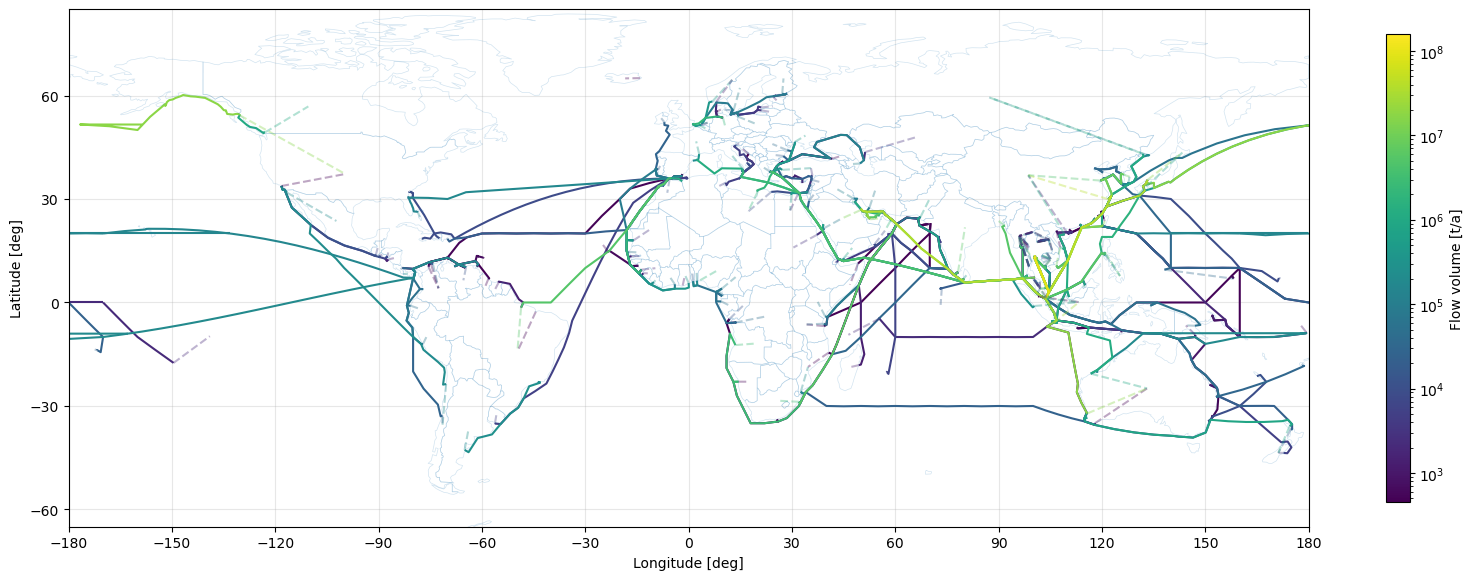

In [55]:
edges = data["nominal"]["edges"]
edges = edges.loc[(edges.volume_tons != 0) & edges["mode"].isin({"maritime", "imaginary"}), :]
vmin = edges.volume_tons.quantile(0.1)
vmax = edges.volume_tons.max()
plot_global_trade_flows(data["nominal"]["edges"], "trade_flow_allocation_global.png", vmin, vmax)

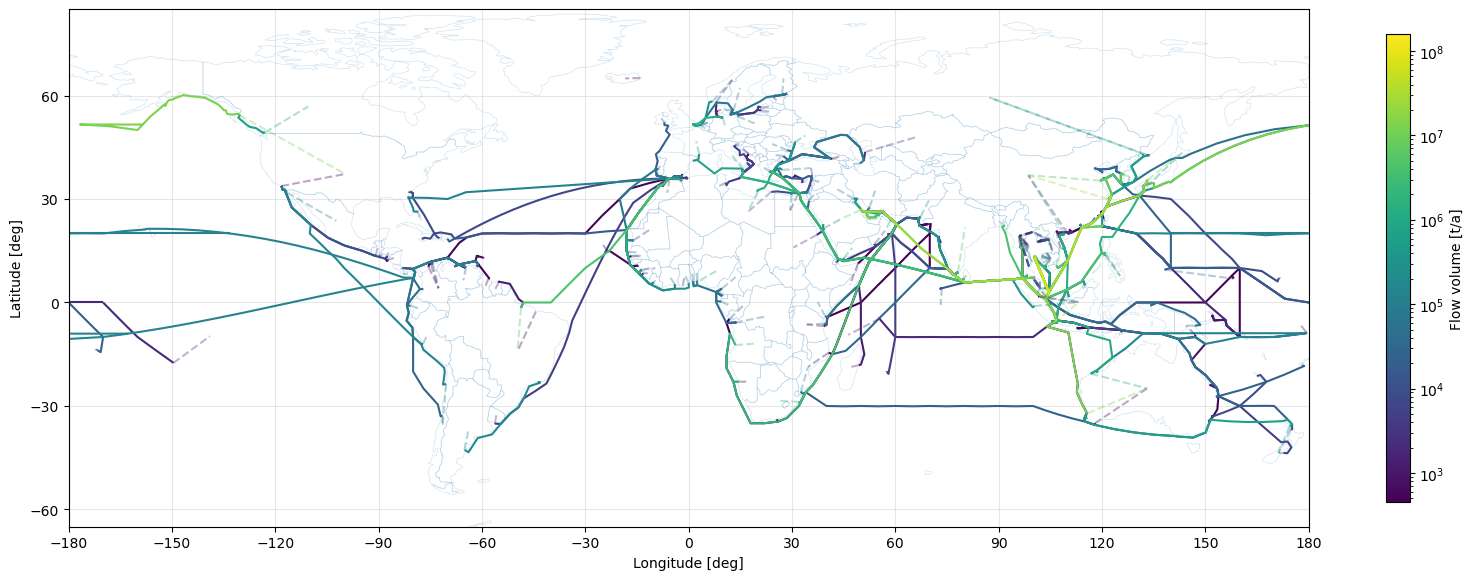

In [56]:
plot_global_trade_flows(data["degraded"]["edges"], "trade_flow_allocation_global_degraded.png", vmin, vmax)

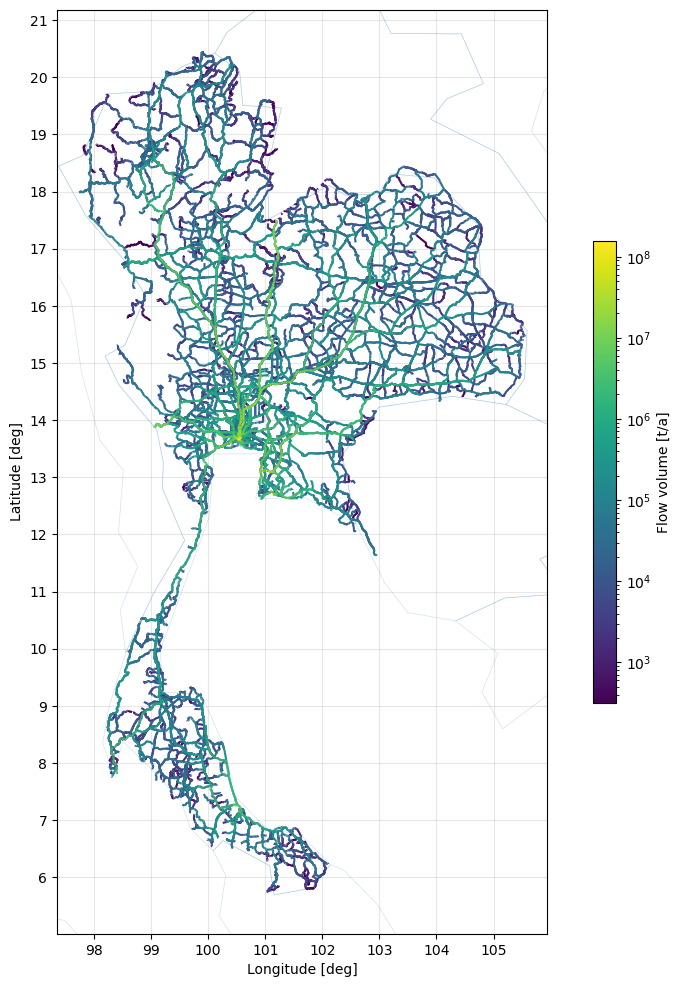

In [57]:
edges = data["nominal"]["edges"]
edges = edges.loc[
    (edges.volume_tons != 0) & edges["mode"].isin({'road_rail','maritime_road','maritime_rail','road','rail'})
]
vmin = edges.volume_tons.quantile(0.1)
vmax = edges.volume_tons.max()
plot_in_country_trade_flows(data["nominal"]["edges"], "trade_flow_allocation_local.png", vmin, vmax)

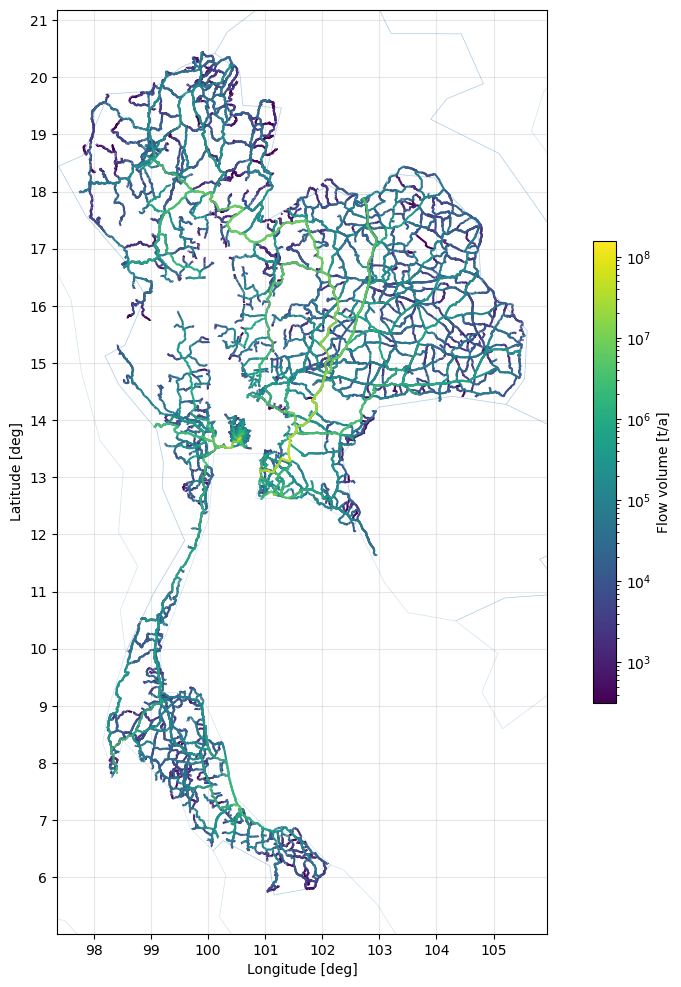

In [58]:
plot_in_country_trade_flows(data["degraded"]["edges"], "trade_flow_allocation_local_degraded.png", vmin, vmax)

In [45]:
# fraction of trade value successfully routed given degraded network 
data["degraded"]["routes"].value_kusd.sum() / data["nominal"]["routes"].value_kusd.sum()

0.8483398026172538

In [46]:
# fraction of trade volume successfully routed given degraded network 
data["degraded"]["routes"].volume_tons.sum() / data["nominal"]["routes"].volume_tons.sum()

0.8528399708134686

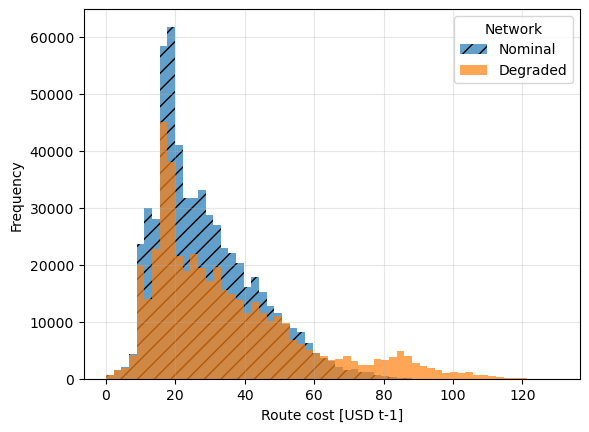

In [62]:
f, ax = plt.subplots()
bins = np.linspace(0.1, 130, 60)
alpha = 0.7
data["nominal"]["routes"].cost_USD_t.hist(
    ax=ax,
    bins=bins,
    alpha=alpha,
    hatch="//",
    label=f"Nominal"
)
data["degraded"]["routes"].cost_USD_t.hist(
    ax=ax,
    bins=bins,
    alpha=alpha,
    label=f"Degraded"
)
ax.legend(title="Network")
ax.grid(alpha=0.3)
ax.set_xlabel("Route cost [USD t-1]")
ax.set_ylabel("Frequency")
f.savefig("route_cost_comparison.png")